In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output

import numpy as np
import pylab as pl

from src import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8     # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5

torch.backends.cudnn.benchmark = True # Speeds up things

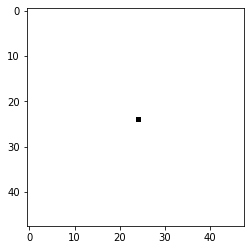

In [31]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

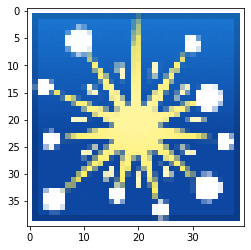

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)

In [33]:
# loads a pretrained model
old_CA = NeuralCA().to(device)
folder = "Pretrained_models/"
old_CA.load(folder + "firework_persistent.pt")

Successfully loaded model!


In [34]:
new_CA = NeuralCA().to(device)
new_CA.load(folder + "Perturbation/fw to lizard.pt")

Successfully loaded model!


In [35]:
model = PerturbationCA(old_CA, new_CA)

In [9]:
# Train the model
for param in model.old_CA.parameters():
    param.requires_grad = False

wandb.init(mode="disabled")
optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=1e-5)
criterion = NCALoss(pad(target, TARGET_PADDING), torch.nn.MSELoss, l=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80,120], gamma=0.3)

model.train_CA(optimizer, criterion, pool, n_epochs=120, skip_update=4,
               scheduler=scheduler, kind="regenerating", skip_damage=2, batch_size=5)

KeyboardInterrupt: 

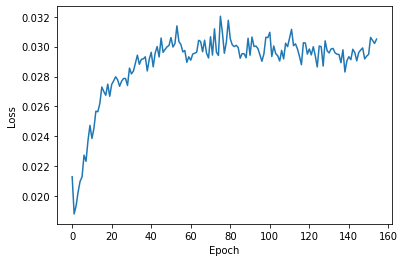

In [12]:
pl.plot(model.losses)
pl.xlabel("Epoch")
pl.ylabel("Loss")
pl.show()
# pl.savefig(fname="pertutbation_regeneration_l=1_side=20_losses.png", dpi=200)

In [9]:
with torch.no_grad():
    for i in range(POOL_SIZE//32 * 2):
        x, idx = pool.sample(32)
        x = x.to(device)
        for i in range(55):
            x = model.forward(x)
        pool.update(idx, x)


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [41]:
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

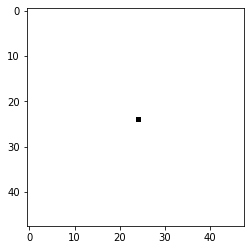

In [38]:
norms_old = []
norms_new = []
with torch.no_grad():
    x = pool.sample(1)[0].cuda()
    imshow(x[0].cpu())
    for i in range(1000):
        pre_life_mask = get_living_mask(x, 3)

        dx_new = model.new_CA.compute_dx(x)
        dx_old = model.old_CA.compute_dx(x)

        post_life_mask = get_living_mask(x, 3)
        life_mask = pre_life_mask & post_life_mask

        norm = torch.mean((dx_new*life_mask)**2)
        norms_new.append(norm.detach().cpu().item())
        norm = torch.mean((dx_old*life_mask)**2)
        norms_old.append(norm.detach().cpu().item())
        x = model.forward(x)

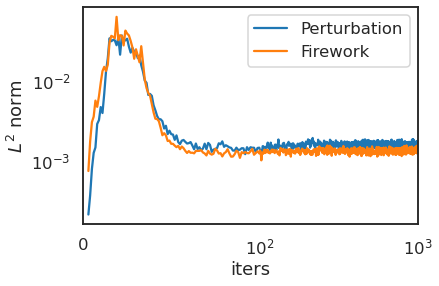

In [42]:
iters = list(range(1, len(norms_new)+1))
pl.plot(iters[2:], norms_new[2:], label="Perturbation")
pl.plot(iters[2:], norms_old[2:], label="Firework")
pl.yscale("log")
pl.xscale("symlog", linthresh=100)
pl.xlim((0, 1000))
pl.xlabel("iters")

pl.ylabel("$L^2$ norm")
pl.legend(bbox_to_anchor=(1, 1))
pl.savefig("firework to lizard.png", dpi=200, bbox_inches="tight")
pl.show()

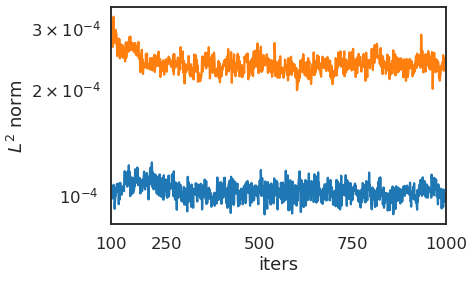

In [104]:
iters = list(range(1, len(norms_new)+1))
pl.plot(iters[100:], norms_new[100:], label="Perturbation")
pl.plot(iters[100:], norms_old[100:], label="Growing")
pl.yscale("log")
pl.xticks([100, 250, 500, 750, 1000])
pl.xlim((100, 1000))
pl.xlabel("iters")

pl.ylabel("$L^2$ norm")
#pl.legend()
pl.savefig("perturbation_norms_l=30 1.png", dpi=200, bbox_inches="tight")
pl.show()

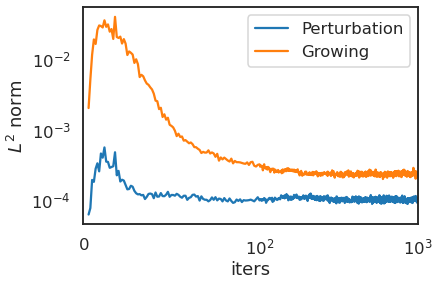

In [105]:
iters = list(range(1, len(norms_new)+1))
pl.plot(iters[2:], norms_new[2:], label="Perturbation")
pl.plot(iters[2:], norms_old[2:], label="Growing")
pl.yscale("log")
pl.xscale("symlog", linthresh=100)
pl.xlim((0, 1000))
pl.xlabel("iters")

pl.ylabel("$L^2$ norm")
pl.legend(bbox_to_anchor=(1, 1))
pl.savefig("perturbation_norms_l=30 2.png", dpi=200, bbox_inches="tight")
pl.show()

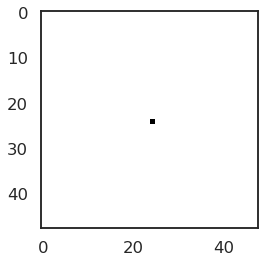

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


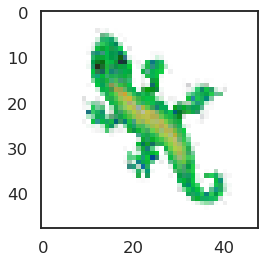

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


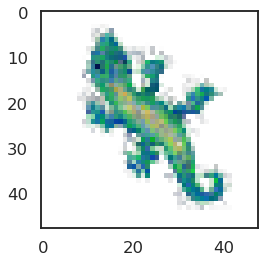

In [54]:
image = pool.sample(1)[0].cuda()

imshow(image[0].cpu())

image = model.evolve(image.cuda(), 200)

imshow(image[0].cpu())

imshow(model.old_CA.evolve(image.cuda(), 5)[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


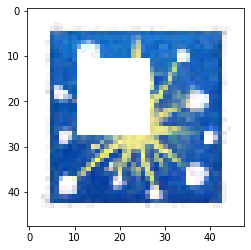

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


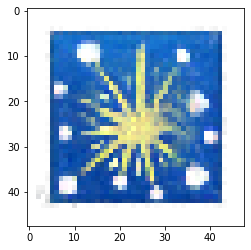

In [50]:
# Plots the learned CA
x, _ = pool.sample(1)

imshow(x[0])
x = x.to(device)
x = model.evolve(x, 550)

imshow(x[0])

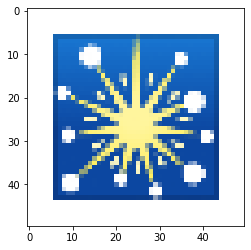

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))